In [1]:
from Bio import SeqIO
import pandas as pd
MAIN_DIR = "/kaggle/input/cafa-5-protein-function-prediction"

# UTILITARIES
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# WANDB FOR LIGHTNING :
import wandb

# FILES VISUALIZATION
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-5-protein-function-prediction/IA.txt
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset.fasta
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset-taxon-list.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta
/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo
/kaggle/input/cafa5-esm-2-3b-various-poolings/train_ids.npy
/kaggle/input/cafa5-esm-2-3b-various-poolings/test_ids.npy
/kaggle/input/cafa5-esm-2-3b-various-poolings/mean/train_embeddings.npy
/kaggle/input/cafa5-esm-2-3b-various-poolings/mean/test_embeddings.npy
/kaggle/input/cafa5-esm-2-3b-various-poolings/sum/train_embeddings.npy
/kaggle/input/cafa5-esm-2-3b-various-poolings/sum/test_embeddings.npy
/kagg

In [2]:
class config:
    train_sequences_path = MAIN_DIR  + "/Train/train_sequences.fasta"
    train_labels_path = MAIN_DIR + "/Train/train_terms.tsv"
    test_sequences_path = MAIN_DIR + "/Test (Targets)/testsuperset.fasta"
    
    num_labels = 500
    n_epochs = 35
    batch_size = 128
    lr = 0.001
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print("Load ProtBERT Model...")
# PROT BERT LOADING :
from transformers import BertModel, BertTokenizer
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert").to(config.device)

Load ProtBERT Model...


Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
print("GENERATE TARGETS FOR ENTRY IDS ("+str(config.num_labels)+" MOST COMMON GO TERMS)")
ids = np.load("/kaggle/input/cafa5-esm-2-3b-various-poolings/train_ids.npy")
labels = pd.read_csv(config.train_labels_path, sep = "\t")

top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
labels_names = top_terms[:config.num_labels].index.values
train_labels_sub = labels[(labels.term.isin(labels_names)) & (labels.EntryID.isin(ids))]
id_labels = train_labels_sub.groupby('EntryID')['term'].apply(list).to_dict()

go_terms_map = {label: i for i, label in enumerate(labels_names)}
labels_matrix = np.empty((len(ids), len(labels_names)))

for index, id in tqdm(enumerate(ids)):
    id_gos_list = id_labels[id]
    temp = [go_terms_map[go] for go in labels_names if go in id_gos_list]
    labels_matrix[index, temp] = 1

np.save("/kaggle/working/train_targets_top"+str(config.num_labels)+".npy", np.array(labels_matrix))
print("GENERATION FINISHED!")

GENERATE TARGETS FOR ENTRY IDS (500 MOST COMMON GO TERMS)


142246it [01:06, 2146.05it/s]


GENERATION FINISHED!


In [5]:
# Directories for the different embedding vectors : 
embeds_map = {
    'ids' : "cafa5-esm-2-3b-various-poolings/",
    "cls" : "cafa5-esm-2-3b-various-poolings/cls",
    "sum" : "cafa5-esm-2-3b-various-poolings/sum",
    "mean" : "cafa5-esm-2-3b-various-poolings/mean"
}

# Length of the different embedding vectors :
embeds_dim = {
    "ESM2" : 2560
}

In [6]:
class ProteinSequenceDataset(Dataset):
    def __init__(self, datatype, pooling_method):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype
        
        if pooling_method in ['cls', 'sum', 'mean']:
            embeds = np.load("/kaggle/input/"+embeds_map[pooling_method]+"/"+datatype+"_embeddings.npy")
            ids = np.load("/kaggle/input/"+embeds_map['ids']+"/"+datatype+"_ids.npy")
        embeds_list = []
        for l in range(embeds.shape[0]):
            embeds_list.append(embeds[l,:])
        self.df = pd.DataFrame(data={"EntryID": ids, "embed": embeds_list})
        if datatype=="train":
            labels_vect = np.load("/kaggle/working/train_targets_top"+str(config.num_labels)+".npy")
            df_labels = pd.DataFrame({"EntryID": ids, "labels_vect": labels_vect.tolist()})
#             df_labels = pd.read_pickle(
#                 "/kaggle/working/train_targets_top"+str(config.num_labels)+".pkl")
            self.df = self.df.merge(df_labels, on="EntryID")
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]['embed'], dtype=torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype=torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id

In [7]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        
        self.linear1 = torch.nn.Linear(input_dim, 1012)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(1012, 712)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(712, 356)
        self.activation3 = torch.nn.ReLU()
        self.linear4 = torch.nn.Linear(356, num_classes)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        x = self.linear4(x)
        return x

In [8]:
def train_model(pooling_method, model_type="linear", train_size=0.9):
    train_dataset = ProteinSequenceDataset(datatype="train", pooling_method = pooling_method)
    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.batch_size, shuffle=True)

    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim["ESM2"], num_classes=config.num_labels).to(config.device)

    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=config.num_labels).to(config.device)
    n_epochs = config.n_epochs
    
    print("BEGIN TRAINING...")
    train_loss_history=[]
    val_loss_history=[]
    
    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(config.device), targets.to(config.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item()) 
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)
        
        
        ## VALIDATION PHASE : 
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(config.device), targets.to(config.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)
        
        scheduler.step(avg_loss)
        print("\n")
        
    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])
    
    
    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}
    
    return model, losses_history, scores_history

In [9]:
mean_model, mean_losses, mean_scores = train_model(pooling_method="mean",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 1001/1001 [00:36<00:00, 27.26it/s]


Running Average TRAIN Loss :  133.35389275031608
Running Average TRAIN F1-Score :  0.1483635292253592
Running Average VAL Loss :  130.08313165392195
Running Average VAL F1-Score :  0.1764844371271985


EPOCH  2


100%|██████████| 1001/1001 [00:32<00:00, 30.52it/s]


Running Average TRAIN Loss :  129.00512753237973
Running Average TRAIN F1-Score :  0.18657611066347116
Running Average VAL Loss :  127.59668649945941
Running Average VAL F1-Score :  0.1924985507503152


EPOCH  3


100%|██████████| 1001/1001 [00:32<00:00, 30.57it/s]


Running Average TRAIN Loss :  127.53518317010138
Running Average TRAIN F1-Score :  0.19685279199114808
Running Average VAL Loss :  127.26230219432286
Running Average VAL F1-Score :  0.19791607412376575


EPOCH  4


100%|██████████| 1001/1001 [00:32<00:00, 30.57it/s]


Running Average TRAIN Loss :  126.44963353449529
Running Average TRAIN F1-Score :  0.20598350212231026
Running Average VAL Loss :  126.59453078678676
Running Average VAL F1-Score :  0.20678546306278026


EPOCH  5


100%|██████████| 1001/1001 [00:32<00:00, 30.61it/s]


Running Average TRAIN Loss :  125.44325776152559
Running Average TRAIN F1-Score :  0.21301893302640476
Running Average VAL Loss :  125.88910940715245
Running Average VAL F1-Score :  0.2122290332668594


EPOCH  6


100%|██████████| 1001/1001 [00:32<00:00, 31.08it/s]


Running Average TRAIN Loss :  124.59992159329929
Running Average TRAIN F1-Score :  0.21999198344203977
Running Average VAL Loss :  125.13545594896588
Running Average VAL F1-Score :  0.21756889591259615


EPOCH  7


100%|██████████| 1001/1001 [00:32<00:00, 30.98it/s]


Running Average TRAIN Loss :  123.81466297526936
Running Average TRAIN F1-Score :  0.22609378704122016
Running Average VAL Loss :  124.89024625505719
Running Average VAL F1-Score :  0.2171539214572736


EPOCH  8


100%|██████████| 1001/1001 [00:32<00:00, 30.99it/s]


Running Average TRAIN Loss :  123.09749409678456
Running Average TRAIN F1-Score :  0.23196775507140946
Running Average VAL Loss :  125.16215998785836
Running Average VAL F1-Score :  0.2220042852152671


EPOCH  9


100%|██████████| 1001/1001 [00:32<00:00, 30.57it/s]


Running Average TRAIN Loss :  122.40282082724404
Running Average TRAIN F1-Score :  0.23760952326384457
Running Average VAL Loss :  124.28032766069684
Running Average VAL F1-Score :  0.22610509927783692


EPOCH  10


100%|██████████| 1001/1001 [00:32<00:00, 31.00it/s]


Running Average TRAIN Loss :  121.69985695152016
Running Average TRAIN F1-Score :  0.24246658575344276
Running Average VAL Loss :  125.23037120274135
Running Average VAL F1-Score :  0.22730906627007894


EPOCH  11


100%|██████████| 1001/1001 [00:32<00:00, 31.14it/s]


Running Average TRAIN Loss :  121.06571197509766
Running Average TRAIN F1-Score :  0.24702509255199642
Running Average VAL Loss :  124.89154345648629
Running Average VAL F1-Score :  0.22937476342277868


EPOCH  12


100%|██████████| 1001/1001 [00:32<00:00, 31.07it/s]


Running Average TRAIN Loss :  118.89803798191555
Running Average TRAIN F1-Score :  0.2584782006232055
Running Average VAL Loss :  123.89271906444004
Running Average VAL F1-Score :  0.23597404094679014


EPOCH  13


100%|██████████| 1001/1001 [00:32<00:00, 30.94it/s]


Running Average TRAIN Loss :  118.360283408608
Running Average TRAIN F1-Score :  0.26140402142073843
Running Average VAL Loss :  123.86343199866158
Running Average VAL F1-Score :  0.2376993704321129


EPOCH  14


100%|██████████| 1001/1001 [00:32<00:00, 30.97it/s]


Running Average TRAIN Loss :  118.14092150220385
Running Average TRAIN F1-Score :  0.26327899141566496
Running Average VAL Loss :  124.02909312929425
Running Average VAL F1-Score :  0.23806685701544797


EPOCH  15


100%|██████████| 1001/1001 [00:32<00:00, 31.07it/s]


Running Average TRAIN Loss :  117.94751229605356
Running Average TRAIN F1-Score :  0.26510880012195426
Running Average VAL Loss :  124.11257246562413
Running Average VAL F1-Score :  0.23846380173095635


EPOCH  16


100%|██████████| 1001/1001 [00:32<00:00, 30.92it/s]


Running Average TRAIN Loss :  117.6269475001317
Running Average TRAIN F1-Score :  0.2669393458328285
Running Average VAL Loss :  124.34270988191876
Running Average VAL F1-Score :  0.2391379394435457


EPOCH  17


100%|██████████| 1001/1001 [00:32<00:00, 30.80it/s]


Running Average TRAIN Loss :  117.5289463039402
Running Average TRAIN F1-Score :  0.2671586539927539
Running Average VAL Loss :  123.97250843048096
Running Average VAL F1-Score :  0.23887733010841267


EPOCH  18


100%|██████████| 1001/1001 [00:32<00:00, 30.91it/s]


Running Average TRAIN Loss :  117.515568819913
Running Average TRAIN F1-Score :  0.26743343841660394
Running Average VAL Loss :  124.09319904872349
Running Average VAL F1-Score :  0.23872416506388358


EPOCH  19


100%|██████████| 1001/1001 [00:32<00:00, 30.79it/s]


Running Average TRAIN Loss :  117.49621735228882
Running Average TRAIN F1-Score :  0.2675787227434831
Running Average VAL Loss :  124.11428083692279
Running Average VAL F1-Score :  0.23900423771036522


EPOCH  20


100%|██████████| 1001/1001 [00:32<00:00, 30.75it/s]


Running Average TRAIN Loss :  117.47559693571809
Running Average TRAIN F1-Score :  0.2674881994545638
Running Average VAL Loss :  124.15583181381226
Running Average VAL F1-Score :  0.23918121374611342


EPOCH  21


100%|██████████| 1001/1001 [00:32<00:00, 30.96it/s]


Running Average TRAIN Loss :  117.4915117917361
Running Average TRAIN F1-Score :  0.2676586047276393
Running Average VAL Loss :  124.39836740493774
Running Average VAL F1-Score :  0.23931166542960064


EPOCH  22


100%|██████████| 1001/1001 [00:32<00:00, 30.92it/s]


Running Average TRAIN Loss :  117.49391745949363
Running Average TRAIN F1-Score :  0.26739221242638855
Running Average VAL Loss :  124.1300505229405
Running Average VAL F1-Score :  0.23864201941926563


EPOCH  23


100%|██████████| 1001/1001 [00:32<00:00, 31.04it/s]


Running Average TRAIN Loss :  117.47510325063121
Running Average TRAIN F1-Score :  0.2673414000919411
Running Average VAL Loss :  123.95735209328788
Running Average VAL F1-Score :  0.2393659297376871


EPOCH  24


100%|██████████| 1001/1001 [00:32<00:00, 30.98it/s]


Running Average TRAIN Loss :  117.46738450605791
Running Average TRAIN F1-Score :  0.26753964945748376
Running Average VAL Loss :  124.0283682686942
Running Average VAL F1-Score :  0.23878218313413008


EPOCH  25


100%|██████████| 1001/1001 [00:32<00:00, 31.04it/s]


Running Average TRAIN Loss :  117.5352085124958
Running Average TRAIN F1-Score :  0.26751433632947824
Running Average VAL Loss :  123.92912060873849
Running Average VAL F1-Score :  0.23911212883623584


EPOCH  26


100%|██████████| 1001/1001 [00:32<00:00, 30.84it/s]


Running Average TRAIN Loss :  117.49309401078658
Running Average TRAIN F1-Score :  0.2675895976734447
Running Average VAL Loss :  123.9888025011335
Running Average VAL F1-Score :  0.23903678903090103


EPOCH  27


100%|██████████| 1001/1001 [00:32<00:00, 30.81it/s]


Running Average TRAIN Loss :  117.47401121827392
Running Average TRAIN F1-Score :  0.2673352997411381
Running Average VAL Loss :  124.18672922679356
Running Average VAL F1-Score :  0.23897695674427918


EPOCH  28


100%|██████████| 1001/1001 [00:32<00:00, 30.92it/s]


Running Average TRAIN Loss :  117.50304099586937
Running Average TRAIN F1-Score :  0.26764734284384745
Running Average VAL Loss :  124.1929509980338
Running Average VAL F1-Score :  0.23998090558286225


EPOCH  29


100%|██████████| 1001/1001 [00:32<00:00, 30.71it/s]


Running Average TRAIN Loss :  117.50578466638342
Running Average TRAIN F1-Score :  0.26771531220559
Running Average VAL Loss :  124.3736013684954
Running Average VAL F1-Score :  0.23974761114056622


EPOCH  30


100%|██████████| 1001/1001 [00:32<00:00, 30.97it/s]


Running Average TRAIN Loss :  117.55156275609157
Running Average TRAIN F1-Score :  0.2675483036082941
Running Average VAL Loss :  124.61239978245327
Running Average VAL F1-Score :  0.23885672645909445


EPOCH  31


100%|██████████| 1001/1001 [00:32<00:00, 30.98it/s]


Running Average TRAIN Loss :  117.49499226664449
Running Average TRAIN F1-Score :  0.2674081867093687
Running Average VAL Loss :  124.17514187949044
Running Average VAL F1-Score :  0.2387377249875239


EPOCH  32


100%|██████████| 1001/1001 [00:32<00:00, 30.59it/s]


Running Average TRAIN Loss :  117.51720048902513
Running Average TRAIN F1-Score :  0.2677636729343073
Running Average VAL Loss :  124.49669245311192
Running Average VAL F1-Score :  0.23955830319651536


EPOCH  33


100%|██████████| 1001/1001 [00:32<00:00, 30.84it/s]


Running Average TRAIN Loss :  117.45407178042295
Running Average TRAIN F1-Score :  0.2675802199231399
Running Average VAL Loss :  123.99019922528949
Running Average VAL F1-Score :  0.23882767691143922


EPOCH  34


100%|██████████| 1001/1001 [00:32<00:00, 30.75it/s]


Running Average TRAIN Loss :  117.48465895676588
Running Average TRAIN F1-Score :  0.26728111283702927
Running Average VAL Loss :  124.53466524396624
Running Average VAL F1-Score :  0.2390823562496475


EPOCH  35


100%|██████████| 1001/1001 [00:32<00:00, 30.69it/s]


Running Average TRAIN Loss :  117.52723421750369
Running Average TRAIN F1-Score :  0.2674698652206482
Running Average VAL Loss :  123.95697348458427
Running Average VAL F1-Score :  0.23935218547870005


TRAINING FINISHED
FINAL TRAINING SCORE :  0.2674698652206482
FINAL VALIDATION SCORE :  0.23935218547870005


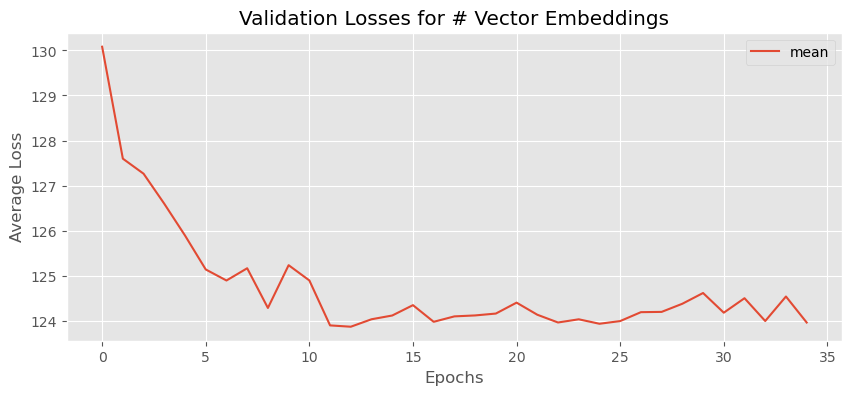

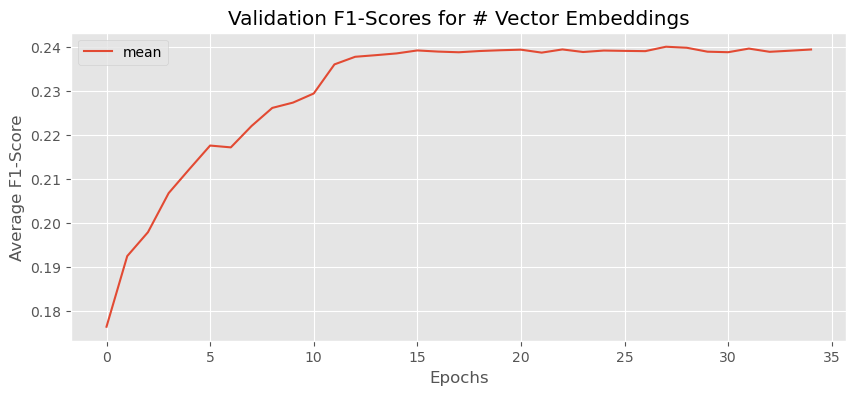

In [10]:
plt.figure(figsize = (10, 4))
#plt.plot(cls_losses["val"], label = "cls")
#plt.plot(sum_losses["val"], label = "sum")
plt.plot(mean_losses["val"], label = "mean")
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
#plt.plot(cls_scores["val"], label = "cls")
#plt.plot(sum_scores["val"], label = "sum")
plt.plot(mean_scores["val"], label = "mean")
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

In [11]:
def predict(pooling_method):
    
    test_dataset = ProteinSequenceDataset(datatype="test", pooling_method = pooling_method)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    model = mean_model
        
    model.eval()
    
    labels = pd.read_csv(config.train_labels_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = top_terms[:config.num_labels].index.values
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(config.device)
        confs_[i*config.num_labels:(i+1)*config.num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*config.num_labels:(i+1)*config.num_labels] = id[0]
        go_terms_[i*config.num_labels:(i+1)*config.num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [12]:
submission_df = predict("mean")

GENERATE PREDICTION FOR TEST SET...


141865it [01:42, 1384.57it/s]


PREDICTIONS DONE


In [13]:
submission_df.head(50)

,Id,GO term,Confidence
0,Q9CQV8,GO:0005575,0.852455
1,Q9CQV8,GO:0008150,0.868588
2,Q9CQV8,GO:0110165,0.854593
3,Q9CQV8,GO:0003674,0.867276
4,Q9CQV8,GO:0005622,0.834764
5,Q9CQV8,GO:0009987,0.823929
6,Q9CQV8,GO:0043226,0.767210
7,Q9CQV8,GO:0043229,0.743187
8,Q9CQV8,GO:0005488,0.882115
9,Q9CQV8,GO:0043227,0.755724


In [14]:
submission_df.to_csv('submission.tsv', sep='\t', index=False)